# 1 Blurring Single Face from an image using Azure Face API

We are going to use Azure Face API to detect any face(s) from an image.<br>
Then we can blur the face or replace it with any image in order to hide the face.

https://docs.microsoft.com/en-us/azure/cognitive-services/face/

In [1]:
#pip install azure-cognitiveservices-vision-face

In [2]:
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
import requests
import matplotlib.pyplot as plt
import cv2
import time
import numpy as np
import os.path
from os import path

In [3]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [4]:
IMAGES_DIR = 'images'

In [5]:
IMAGE_FILE = IMAGES_DIR + '/image1.jpg'

In [6]:
image = cv2.imread(IMAGE_FILE)
h, w, c = image.shape
print('Width:', w)
print('Height:', h)
print('Channel:', c)
print('Size:', image.size)

Width: 1008
Height: 672
Channel: 3
Size: 2032128


In [7]:
def ViewImageFile(image_file):
    image = cv2.imread(image_file)
    plt.figure(figsize = (12, 12))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

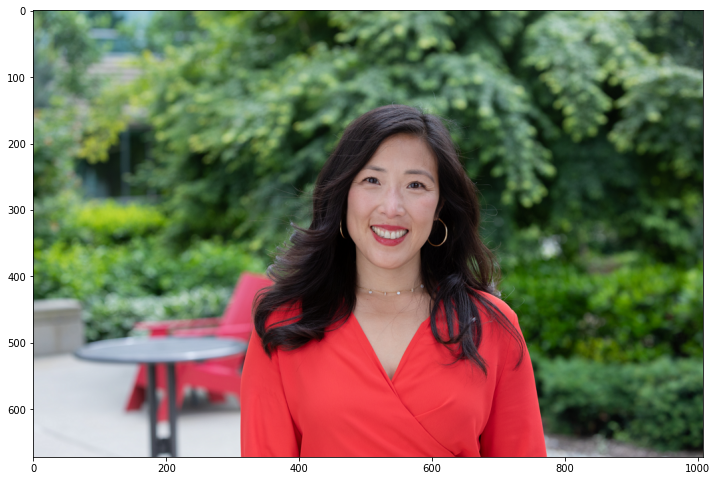

In [8]:
ViewImageFile(IMAGE_FILE)

## Face API

We are going to use the Azure Face API.
In the config.ini file there are the two values that are required to use the Azure Face API service (its endpoint and its key)

In [9]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')
config.sections()

['AzureFaceAPI']

In [10]:
faceapi_key = config.get('AzureFaceAPI', 'faceapi_key')
faceapi_endpoint = config.get('AzureFaceAPI', 'faceapi_endpoint')
face_client = FaceClient(faceapi_endpoint, CognitiveServicesCredentials(faceapi_key))

In [11]:
faceimage = open(IMAGE_FILE, 'rb')

face_api_url = faceapi_endpoint + "face/v1.0/detect"
headers = {'Content-Type': 'application/octet-stream', 
           'Ocp-Apim-Subscription-Key': faceapi_key}

params = {
'returnFaceId': 'true', # To retrieve the ID for each face
'returnFaceLandmarks': 'false', # We do not need the 27 face landmarks
'recognitionModel': 'recognition_04' # Version of the model
}

response = requests.post(face_api_url, params=params, headers=headers, data=faceimage)
response.raise_for_status()
faces = response.json()
faces

[{'faceId': 'aec78311-8448-4899-9c8c-5b265036f4db',
  'faceRectangle': {'top': 217, 'left': 463, 'width': 153, 'height': 153}}]

In [12]:
print("Number of detected faces in the image =", len(faces))

Number of detected faces in the image = 1


## Face ID

In [13]:
for face in faces:
    faceid = face['faceId']
    print("Face ID:", faceid)
    faceRectangle = face['faceRectangle']
    print("Face location:", faceRectangle)

Face ID: aec78311-8448-4899-9c8c-5b265036f4db
Face location: {'top': 217, 'left': 463, 'width': 153, 'height': 153}


## Face ROI

In [14]:
for face in faces:
    top = face['faceRectangle']['top']
    left = face['faceRectangle']['left']
    width = face['faceRectangle']['width']
    height = face['faceRectangle']['height']
    print("Top:", top, "Left:", left, "Width:", width, "Height:", height)

Top: 217 Left: 463 Width: 153 Height: 153


## Face detection

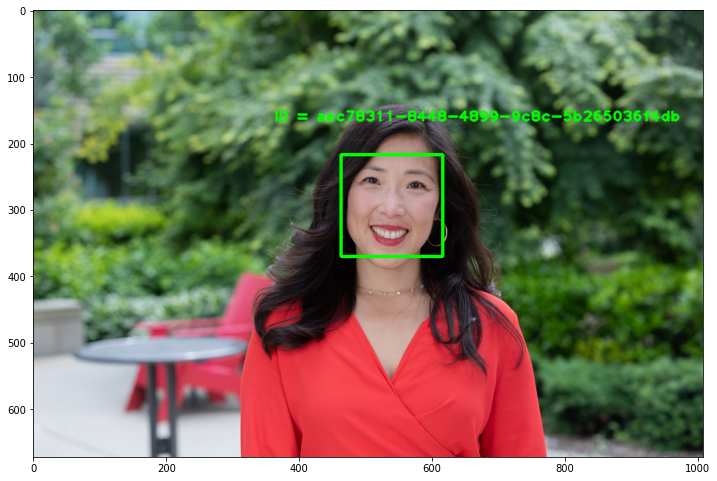

In [15]:
faceimage = image.copy()

result_image = cv2.rectangle(faceimage, (left, top), (left + width, top + height), (0, 255, 0), 3)
msg1 = 'ID = ' + str(faceid)
result_image = cv2.putText(result_image, msg1, (left - 100, top - 50), 
                           cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (12, 12))
plt.imshow(result_image_rgb)

## Face Only

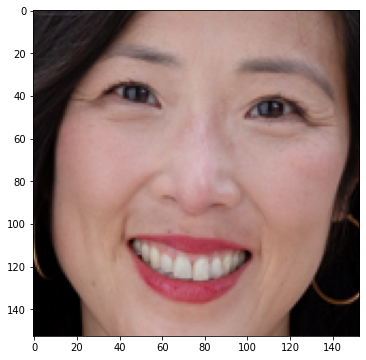

In [16]:
cropface = image.copy()
crop_img = cropface[top:top+height, left:left+width]
crop_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(crop_rgb)

## Blurring Face

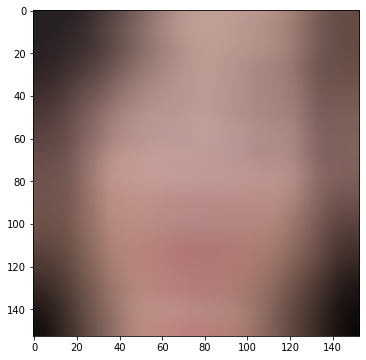

In [17]:
kernel = (50, 50)
crop_blur = cv2.blur(crop_rgb, kernel)
plt.figure(figsize = (6, 6))
plt.imshow(crop_blur)

## Initial image with blurred face

In [18]:
OUTPUT_DIR = 'results'

if path.os.path.isdir(OUTPUT_DIR) :
    print("Directory:", OUTPUT_DIR, "exists")

else:
    print("Creating directory:", OUTPUT_DIR)
    os.mkdir(OUTPUT_DIR)
    print("Done")

Creating directory: results
Done


In [19]:
x_offset = faceRectangle['left']
y_offset = faceRectangle['top']

crop_blur = cv2.cvtColor(crop_blur, cv2.COLOR_BGR2RGB)
initial_image = cv2.imread(IMAGE_FILE)
initial_image[y_offset:y_offset + crop_blur.shape[0], x_offset:x_offset + crop_blur.shape[1]] = crop_blur

blurred_image = OUTPUT_DIR + "/blurred_" + str(os.path.basename(IMAGE_FILE))
cv2.imwrite(blurred_image, initial_image)

True

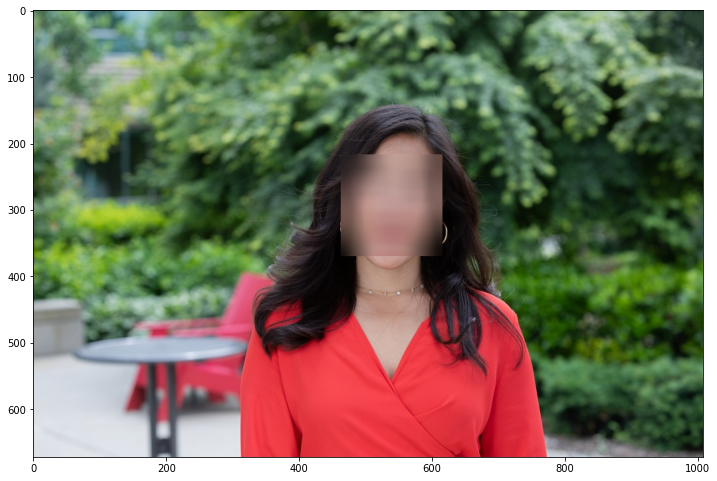

In [20]:
ViewImageFile(blurred_image)

## Let's replace the face with another image

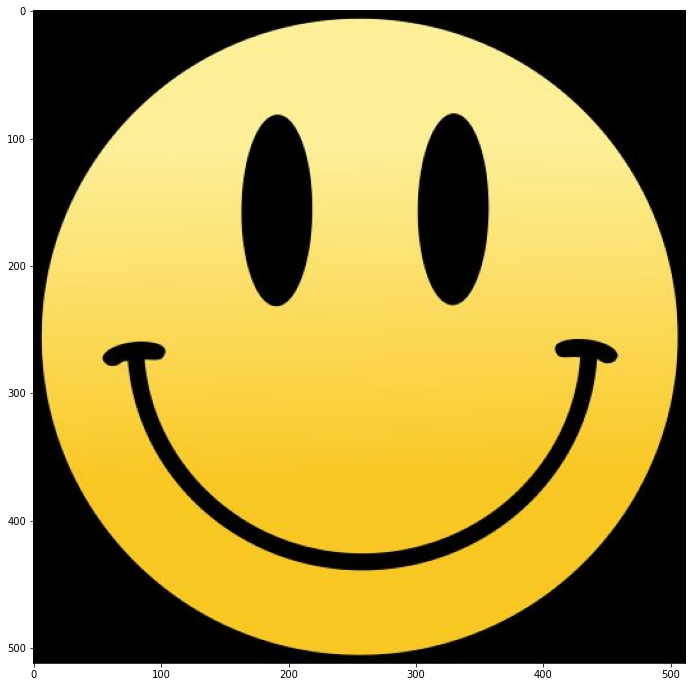

In [21]:
SMILEY = IMAGES_DIR + "/smiley.jpg"
ViewImageFile(SMILEY)

In [22]:
smiley_face = cv2.imread(SMILEY)

x_offset = faceRectangle['left']
y_offset = faceRectangle['top']
w = faceRectangle['width']
h = faceRectangle['height']
smiley_face_resized = cv2.resize(smiley_face, (w, h), interpolation = cv2.INTER_LINEAR) # Resizing the smiley image to the face

initial_image = cv2.imread(IMAGE_FILE)
initial_image[y_offset:y_offset + smiley_face_resized.shape[0], 
              x_offset:x_offset + smiley_face_resized.shape[1]] = smiley_face_resized

smiley_image = OUTPUT_DIR + "/smiley_" + str(os.path.basename(IMAGE_FILE))
cv2.imwrite(smiley_image, initial_image)

True

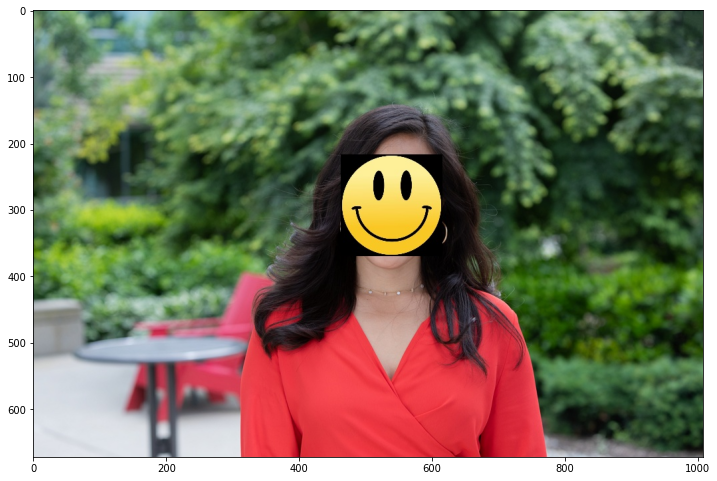

In [23]:
ViewImageFile(smiley_image)

## Let's replace the face with a black rectangle

In [24]:
x_offset = faceRectangle['left']
y_offset = faceRectangle['top']
w = face['faceRectangle']['width']
h = face['faceRectangle']['height']

initial_image = cv2.imread(IMAGE_FILE)
black_rectangle = np.zeros(shape = [w, h, 3], dtype=np.uint8) # Black image
initial_image[y_offset:y_offset + black_rectangle.shape[0], 
              x_offset:x_offset + black_rectangle.shape[1]] = black_rectangle

black_image = OUTPUT_DIR + "/black_" + str(os.path.basename(IMAGE_FILE))
cv2.imwrite(black_image, initial_image)

True

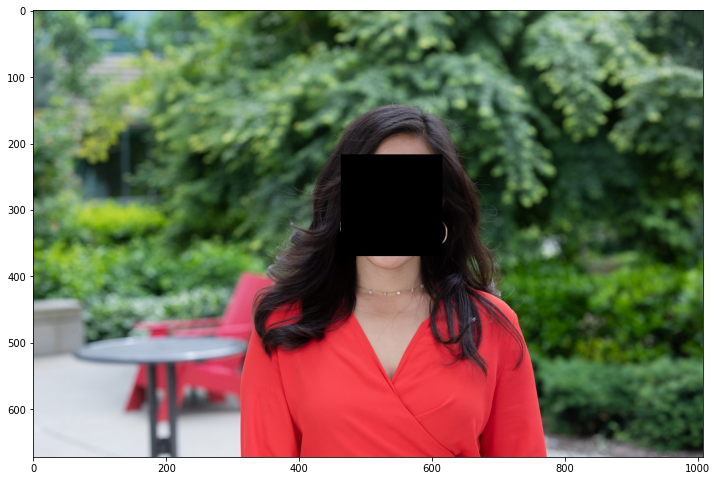

In [25]:
ViewImageFile(black_image)